In [55]:
#Making the standard imports
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
import datetime
import os.path
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
#Defining the moving average strategy
class CrossoverStrategy(bt.Strategy):
    params = dict(pfast=10, pslow=30)
    
    def log(self, message, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(),message))
        
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.price = None
        self.commission = None
        sma_fast = bt.ind.SMA(period=self.params.pfast)
        sma_slow = bt.ind.SMA(period=self.params.pslow)
        self.crossover = bt.ind.CrossOver(sma_fast, sma_slow)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            #Updating and printing the values if the order has gone through
            if order.isbuy():
                self.log('Stock Purchased, Price: %.2f,\tCost: %.2f,\tCommission: %.2f' 
                         %(order.executed.price, order.executed.value, order.executed.comm))
                self.price = order.executed.price
                self.commision = order.executed.comm
                
            else:
                self.log('Stock Sold, Price: %.2f,\tCost: %.2f,\tCommission: %.2f'
                         %(order.executed.price, order.executed.value, order.executed.comm))
                
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        #Any of the above two conditions, there is no pending order and an order can be placed
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %(trade.pnl, trade.pnlcomm))
        
    def next(self):
        #Uncomment the next statement to log all the closing prices  of the series
        #self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return
        
        if not self.position:  #if not in the market
            if self.crossover > 0:
                self.log('Buy Order Placed: %.2f' %self.dataclose[0])
                self.order = self.buy()
                
            
            #Second condition added because it was placing Sell orders even without buying
            elif (self.crossover < 0) & (self.order != None):
                self.log('Sell Order Placed: %.2f' %self.dataclose[0])
                self.order = self.close()        
                #DO NOT use sell here, it will sell the stock even if it is not bought

In [47]:
if __name__ == '__main__':
    
    cerebro = bt.Cerebro()
    cerebro.addstrategy(CrossoverStrategy)
    
    #Data path specific to my computer
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'datas/orcl-1995-2014.txt')
    
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        fromdate=datetime.datetime(2000, 1, 1),
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)
    
    cerebro.broker.setcash(100000.0)
    cerebro.adddata(data)
    cerebro.broker.setcommission(commission=0.001)
    
    initial = cerebro.broker.getvalue()
    print('Initial Portfolio Value: %.2f' %initial)

    cerebro.run()

    #While calculating the final portfolio value, the current closing price of stock is taken, if not sold
    final =  cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' %final)
    print('Net profit/loss on the trade: %.2f' %(final-initial))



Initial Portfolio Value: 100000.00
2000-06-08 Buy Order Placed: 36.64
2000-06-09 Stock Purchased, Price: 36.86,	Cost: 36.86,	Commission: 0.04
Final Portfolio Value: 99988.95
Net profit/loss on the trade: -11.05


<IPython.core.display.Javascript object>


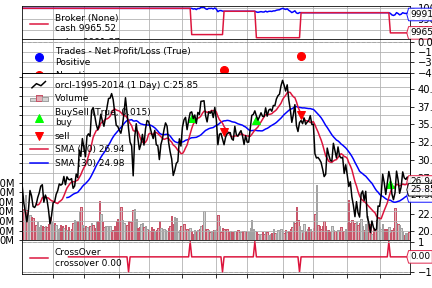

[[<Figure size 432x288 with 5 Axes>]]

In [50]:
cerebro.plot()